### Data Preparation for Bayesian Filter

install dependencies....

In [33]:
!pip install beautifulsoup4

In [34]:
!pip install wordcloud

In [35]:
#we are importing all the libraries we would like to use.
#including data stores for stopwords and such
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import os
import io
%matplotlib inline

### This function reads the files in the specified path.

In [36]:
def read_files(path):
    #this function is reading the actual email files.
    #the function will cycle through all the files in the folder specified.
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root,filename)
            
            inBody = False
            lines = []
            #this uses IO functions to read the files by specifying the encoding type
            f = io.open(path, 'r', encoding = 'latin1')
            #this cycles through each line and fetches the text therein.
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            #join the text into a single message.
            message = '\n'.join(lines)
            #return the message
            yield path, message
                    

### This function is for creating dataframes from the dataset in question... it also classifies the emails into either ham or spam

In [37]:
#this classifies the emails into spam or ham depending on predetermined status.
def dataFrameFromDirectory(path, classification):
    #instantiate the structure of the dataframe needed.
    rows = []
    index = []
    #store the message alongside its classification.
    for filename, message in read_files(path):
        rows.append({'message': message, 'label': classification})
        index.append(filename)
        #return the dataframe to be used for manipulation
    return pd.DataFrame(rows, index=index)

aggregate all the emails into a single dataframe. The key is: ham = 0, spam = 1

In [38]:
#fetch the data from the source files.
#here you run the datasets sequentially for validation by specifying file name. 

data = pd.DataFrame({'message':[],'label':[]})
data = data.append(dataFrameFromDirectory("datasets/ham3",0))
data = data.append(dataFrameFromDirectory("datasets/spam3",1))
data

,message,label
datasets/ham2\0004.e8d5727378ddde5c3be181df593f1712,Klez: The Virus That Won't Die\n\n \n\nAlready...,0.0
datasets/ham2\0005.8c3b9e9c0f3f183ddaf7592a11b99957,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0.0
datasets/ham2\0016.d82758030e304d41fb3f4ebbb7d9dd91,Yes - great minds think alike. But even withpu...,0.0
datasets/ham2\0017.d81093a2182fc9135df6d9158a8ebfd6,"On Mon, Aug 19, 2002 at 03:08:16PM +0100, John...",0.0
datasets/ham2\0022.7241da4491c49b50c0470a3638ee35c4,In a nutshell - Solaris is Suns own flavour of...,0.0
...,...,...
datasets/spam2\0490.5fc0d6e9adcaf702bb7dd303ff2d59e2,\n\n--Boundary_(ID_57z4OPjIWZtVBINVV279ZQ)\n\n...,1.0
datasets/spam2\0494.a0865131f55d26362a8efad99c37de01,<html>\n\n<head>\n\n<title>FREESTORES - MAKE M...,1.0
datasets/spam2\0496.e995facc5d5bc6d3f3a8537d35e0432a,There is NO stumbling on to it! \n\n\n\nThe gr...,1.0
datasets/spam2\0497.9307bd1fb5347f9fbf1f54ebe95b1d20,This is a multi-part message in MIME format.\n...,1.0


The below cell shows the number of rows in our dataframe.

In [39]:
total_mails = data['message'].shape[0]
total_mails

600

The function below extracts all text from html text present in all emails.

In [40]:
#this is for scraping the emails, since most are in the form of html based content.
from bs4 import BeautifulSoup

def func(df):
    soup = BeautifulSoup(df['message'], "html.parser").find()
    #check emails with html syntax
    if bool(soup):
        soup = BeautifulSoup(df['message'], "html.parser")
        #extract text only from the whole email.
    
        text = soup.find_all(text=True)
      
        #return all the words found.
        text = ''.join(word for word in  text)
        df['message'] = text
        
        return text
    else:
        
        return df['message'] 

In [41]:
import email

def using_emailing_function(df):

#     msg = email.message_from_string(df['message'])
#     for part in msg.walk():
#         print(df['message'])
        
    msg = email.message_from_string(df['message'])
    if msg.is_multipart():
        for payload in msg.get_payload():
            # if payload.is_multipart(): ...
#             print(payload.get_payload())
            soup = BeautifulSoup(payload.get_payload(), "lxml").find()
            if bool(soup):
                print(payload.get_payload())
            else:
                print(payload.get_payload())
    else:
        soup = BeautifulSoup(msg.get_payload(), "lxml").find()
        if bool(soup):
                print(msg.get_payload())
#         else:
#             print(msg.get_payload())



In [42]:
new_data = data.reset_index()
new_data

,index,message,label
0,datasets/ham2\0004.e8d5727378ddde5c3be181df593...,Klez: The Virus That Won't Die\n\n \n\nAlready...,0.0
1,datasets/ham2\0005.8c3b9e9c0f3f183ddaf7592a11b...,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0.0
2,datasets/ham2\0016.d82758030e304d41fb3f4ebbb7d...,Yes - great minds think alike. But even withpu...,0.0
3,datasets/ham2\0017.d81093a2182fc9135df6d9158a8...,"On Mon, Aug 19, 2002 at 03:08:16PM +0100, John...",0.0
4,datasets/ham2\0022.7241da4491c49b50c0470a3638e...,In a nutshell - Solaris is Suns own flavour of...,0.0
...,...,...,...
595,datasets/spam2\0490.5fc0d6e9adcaf702bb7dd303ff...,\n\n--Boundary_(ID_57z4OPjIWZtVBINVV279ZQ)\n\n...,1.0
596,datasets/spam2\0494.a0865131f55d26362a8efad99c...,<html>\n\n<head>\n\n<title>FREESTORES - MAKE M...,1.0
597,datasets/spam2\0496.e995facc5d5bc6d3f3a8537d35...,There is NO stumbling on to it! \n\n\n\nThe gr...,1.0
598,datasets/spam2\0497.9307bd1fb5347f9fbf1f54ebe9...,This is a multi-part message in MIME format.\n...,1.0


In [43]:
#this removes all text that is not alphanumeric i.e special characters.
new_data[new_data['message'].str.isalnum()]

,index,message,label


split the data into the pareto principle for unbiased model testing.
so 80% will be used for training and 20% for testing.
this will be accomplished by using a random number generator to randomize the order by implementing a uniform distribution randomizer. this removes all chances of having a biased model on account of sequential data.

In [44]:
#split the data into training and testing sets
#initializing empty lists to hold training and testing data respectively
train_index, test_index = list(), list()
for i in range(data['message'].shape[0]):
    #make use of the uniform random distribution to alleviate contiguousness of pseudo-random number generators.
    #80% for training and 20% for testing according to the pareto principle.
    if np.random.uniform(0,1) < 0.80:
        train_index.append(i)
    else:
        test_index.append(i)
#training data dataframe.
train_data = new_data.loc[train_index]
#test data dataframe
test_data = new_data.loc[test_index]

In [45]:
train_data.apply(using_emailing_function, axis = 1) 

 

Already the most prolific virus ever, Klez continues to wreak havoc.



Andrew Brandt

>>From the September 2002 issue of PC World magazine

Posted Thursday, August 01, 2002





The Klez worm is approaching its seventh month of wriggling across 

the Web, making it one of the most persistent viruses ever. And 

experts warn that it may be a harbinger of new viruses that use a 

combination of pernicious approaches to go from PC to PC.



Antivirus software makers Symantec and McAfee both report more than 

2000 new infections daily, with no sign of letup at press time. The 

British security firm MessageLabs estimates that 1 in every 300 

e-mail messages holds a variation of the Klez virus, and says that 

Klez has already surpassed last summer's SirCam as the most prolific 

virus ever.



And some newer Klez variants aren't merely nuisances--they can carry 

other viruses in them that corrupt your data.



...



http://www.pcworld.com/news/article/0,aid,103259,00.asp

_________




> Wrong, [VMS-like async io] makes a huge difference in even what I

> consider small programs.



So it sounds as if, to your thinking,

most useful apps are also trivial. 

Unless each key on my keyboard were

(to the apps) distinct event sources,

I can't think of any of my usual job

mix that would need hundreds, or even

tens, of async requests; perhaps you

can explain how nontrivial apps will

be compellingly useful? 



> but it's still not built in, who knows when it will be. The point is it's

> not portable in either case.



Does that lack of portability imply it

isn't generally useful?  (When it was

apparent that TCP networks were useful,

berkeley sockets could be found even

on VMS and Win 3.1 boxen)



Why would early Unix have run with the

idea that, if one wishes to do multiple

things at the same time, one can use a

group of processes to do them?



- they had Multics as a counterexample?



- in the days of tiny memories and tapes,

  people were more accusto




>>>>> On Fri, 13 Sep 2002, "Tony" == Tony Nugent wrote:



  Tony> I can't even mark text in an exmh message window and then

  Tony> paste it into a terminal window, the cut buffer seems to

  Tony> be completely empty (and its previous contents are no

  Tony> longer there either).



Brent confessed recently that he had tried to subvert the X

model(s) of copy and paste.  Not in those words... but that

was how I read it. ;)



I have a lot of trouble copying and pasting from or to exmh 

across a VNC link (from things in the vncviewer to things not in 

it and vice versa).  As long as I stick to apps being "normally" 

displayed on my X server I don't have much of a problem.



My recollection from my X programming days is that the X model,

like everything in X, is more complex than the human brain can

handle.  It also is very different from the MS-Windows model.

And I get the feeling that Tk tries to "unify" those two models

and fails.  Not sure what the exmh-specific contr

On Wed, Sep 11, 2002 at 01:46:19PM -0700, David Raistrick wrote:

> On Wed, 11 Sep 2002, Stephane Lentz wrote:

> 

> > => I faced a similar problem with the FreeBSD when trying to 

> > install SpamAssassin through the ports on my fresh FreeBSD 4.6.2. 

> > I had to define PERL5LIB with some given order of directories

> > so that the latest File::Spec module get used. 

> 

> Good to hear it's not just me.  Mind telling me how you set PERL5LIB

> specificly? I've tried a few things (setenv in the shell, as well as

> $PERL5LIB == ...inside the Makefile.PL, even on the perl command

> line..) with no success.

> 

- Presuming your run Bash  :

Note the directory lists 

#  perl -e 'map { print "$_\n" } @INC'

Then set up the Shell variable PERL5LIB variable (and put it in some .bashrc 

for future use)

# export PERL5LIB="directory1:directory2:directory3:directory4"

Then try to install the software



PERL5LIB is explained perlrun(1) : do 

# man perlrun for more information



Regar


Date: Tue, 24 Sep 2002 01:16:41 GMT



Halley[1]: "When is someone going to create _audio fonts_ for Christ's sake."



[1] http://halleyscomment.blogspot.com/2002_09_22_halleyscomment_archive.html#85483723





Date: 1/1/1904; 12:00:00 AM



Gold Lake Mountain Resort[1] looks pretty gooood. Man there are a lot of cool 

relaxing places to stay in Colorado. Keep the suggestions coming. 



[1] http://www.goldlake.com/





Date: 2002-09-24T22:05:32-05:00



_Sam Ruby_: Stark raving mad[1]. 



    This post was entered in Radio, extracted using a batch file via some 

    UserTalk, parsed using Perl, cleaned up by tidy and a C program of my own 

    design, transferred to intertwingly using scp, and then ssh triggers 

    unpacking on the destination site, where a shell script takes over: invokes 

    indexing using Jakarta's Lucene, and then a python script pings weblogs.com 

    and blo.gs. 



Tom Stoppard (_Rosencrantz and Guildenstern are Dead_): 



    Guildenstern: &#8220;

Date: 2002-10-10T03:26:56+01:00



*Conservative party conference:* Iain Duncan Smith will today tell the Tory old 

guard to stop sniping at his policy agenda.





Date: 2002-10-09T22:50:35-08:00



My Tivo has been picking up the Twilight Zone for the last few weeks. I have to 

say, I'm really enjoying it. It reminds me of the old ones. It's good to have 

it back on the air....





Date: Not supplied



Government employees are routinely screened in a bid to spot spies - but the 

testing is useless, says influential panel of scientists





Date: 2002-10-10T03:26:58+01:00



Toumai, hailed as our oldest ancestor, is stirring ancient scientific 

rivalries. Quizzes[1] | Crossword[2] | Interactive guides[3] | Steve Bell[4] | 

Weblog[5] *Other news and comment**Blair ready to suspend Stormont*[6]



[1] http://www.newsisfree.com/quiz/0,7476,349695,00.html

[2] http://www.newsisfree.com/crossword/0,4406,180778,00.html

[3] http://www.newsisfree.com/interactive/0,2759,192055,00.html


Targeted email marketing works!  There's no way around it.

No other medium let's you share your offer with more 

people for less than the cost of a small classified ad.



We can supply valid targeted emails according 

to your requirements, which are compiled only on your order, such as region/country/field/keyword/ 

occupation/Domain Name (like AOL.com) etc.







Free membership

Signup today at http://61.151.247.41

Limited membership







This is a one time message, you will not be emailed again.



It was the Spring of 1979.  



I was just a tall, goofy looking kid in middle school

with buck-teeth and freckles.  Each day in the

cafeteria, I walked from table to table ...



Stealing other kids' lunch money.



No, I didn't rob them with a gun or a knife - I just made

them a little deal.  "Let me borrow two dollars today," I said,

"and I'll bring you five dollars next week."  The investment

was too good to pass up, and other kids were throwing their

lunch money at me


This is a multi-part message in MIME format.



------=_NextPart_000_141E89_01C2631C.554EB1D0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: 7bit



 	 Are you ready for 10-5-2002?

 We are!

 	

 	

 	

Act Now... Call us today for more details

 800-550-2666 ext. 150

- or - 



Please fill out the form below for more information	 

Name:	  	 	

E-mail:	  	

Phone:	  	

City:	  	State:	  	

 	    	

 

 Flynn Associates Insurance Marketing, Inc.

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout

<http://www.insuranceiq.com/optout/> 



Legal Notice <http://www.insiq.com/legal.htm> 



------=_NextPart_000_141E89_01C2631C.554EB1D0

Content-Type: text/html;

	charset="iso-8859-1"

Content-Transfer-Encoding: quoted-printable



<html

0      None
1      None
2      None
3      None
4      None
       ... 
595    None
596    None
597    None
598    None
599    None
Length: 487, dtype: object

implement the data cleaning of the html based messages
    

In [46]:
#here we  apply the scraping function to our data. hence cleaning it.
train_data['message'] = train_data.apply(func, axis=1)
test_data['message'] = test_data.apply(func, axis=1)
train_data #its just expecting the data to come from a website and not a dataframe.

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp






" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


,index,message,label
0,datasets/ham2\0004.e8d5727378ddde5c3be181df593...,Klez: The Virus That Won't Die\n\n \n\nAlready...,0.0
1,datasets/ham2\0005.8c3b9e9c0f3f183ddaf7592a11b...,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0.0
2,datasets/ham2\0016.d82758030e304d41fb3f4ebbb7d...,Yes - great minds think alike. But even withpu...,0.0
3,datasets/ham2\0017.d81093a2182fc9135df6d9158a8...,"On Mon, Aug 19, 2002 at 03:08:16PM +0100, John...",0.0
4,datasets/ham2\0022.7241da4491c49b50c0470a3638e...,In a nutshell - Solaris is Suns own flavour of...,0.0
...,...,...,...
595,datasets/spam2\0490.5fc0d6e9adcaf702bb7dd303ff...,\n\n--Boundary_(ID_57z4OPjIWZtVBINVV279ZQ)\n\n...,1.0
596,datasets/spam2\0494.a0865131f55d26362a8efad99c...,\n\nFREESTORES - MAKE MONEY GIVING AWAY FREE S...,1.0
597,datasets/spam2\0496.e995facc5d5bc6d3f3a8537d35...,There is NO stumbling on to it! \n\n\n\nThe gr...,1.0
598,datasets/spam2\0497.9307bd1fb5347f9fbf1f54ebe9...,This is a multi-part message in MIME format.\n...,1.0


In [47]:
import re #regular expression. it is used to perform word searches.

train_data['message'] = train_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))
test_data['message'] = test_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))

In [48]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [49]:
train_data['message'].str.isalnum()

0      False
1      False
2      False
3      False
4      False
       ...  
482    False
483    False
484    False
485    False
486    False
Name: message, Length: 487, dtype: bool

In [50]:
test_data

,index,message,label
0,datasets/ham2\0057.be5e34dcebd922928045634015e...,At 17 10 22 08 2002 0100 Nick Hilliard wrote a...,0.0
1,datasets/ham2\0102.ba8679813c4b5f424fb225f09b2...,On Fri 23 Aug 2002 Robert Harley wrote Next ti...,0.0
2,datasets/ham2\0132.bcd23223120c0be6b991ae0349c...,If you haven t already you should enable the d...,0.0
3,datasets/ham2\0145.7400cf6ab4cfe5ffeaab582c973...,On Sun Oct 06 2002 at 11 10 05PM 0100 Declan d...,0.0
4,datasets/ham2\0149.d59bb0d23ca8ad3a87e549d3e61...,http www washingtonpost com wp dyn articles A4...,0.0
...,...,...,...
108,datasets/spam2\0345.b8ba4d6a115368132d1d580c4c...,000000000000000000000 Content Type text html ...,1.0
109,datasets/spam2\0435.2078783521379b81a45f1a5c48...,The Best Mortage Rates Simple Easy and FREE H...,1.0
110,datasets/spam2\0441.b820c1999715c2e5ded6418d2b...,Never Pay Retail Direct Synergy Household Cre...,1.0
111,datasets/spam2\0444.f81c80c3f2d43ecd8b117213f3...,HTML PUBLIC W3C DTD HTML 4 01 Transitional EN ...,1.0


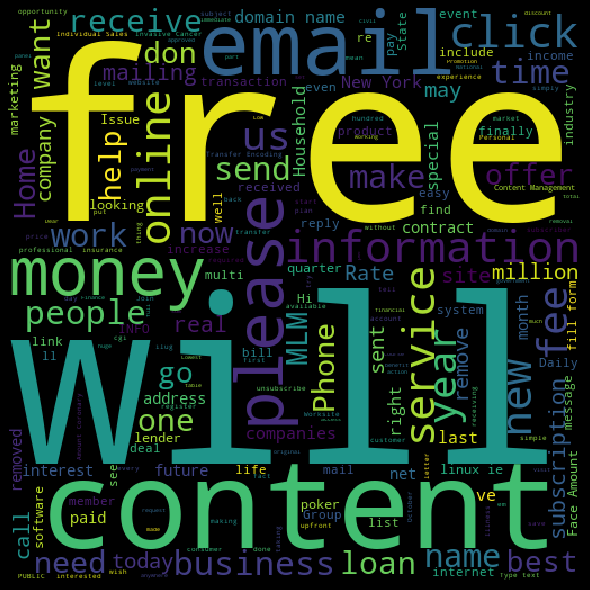

In [51]:
#visual representation of the most salient words.
#this is the visulization for the spam.
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 1]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

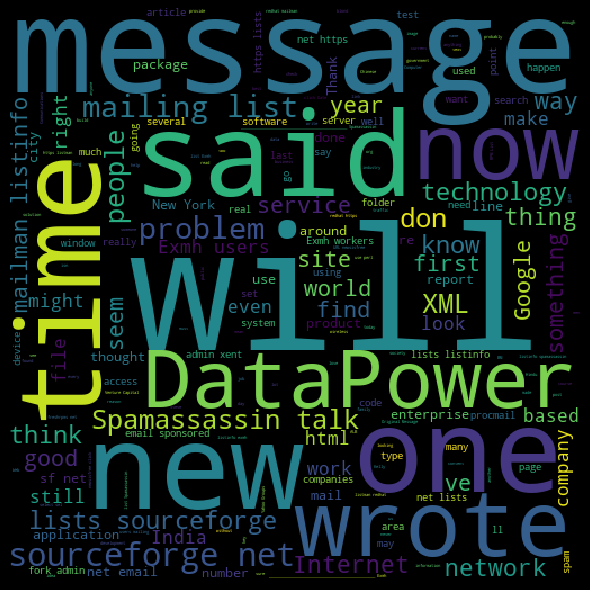

In [52]:
#Visualize the ham data
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 0]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

distribution by value

In [53]:
train_data['label'].value_counts() #remove the paragraph line

0.0    403
1.0     84
Name: label, dtype: int64

In [54]:
#tokenizing and processing the words harnessed.
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    #lower case all the letters in the message.
    if lower_case:
        message = message.lower()
    #break down the words into tokens.
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
#     print(words)
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        #fetch all words that do not have meaning in this case: stopwords.
        sw = stopwords.words('english')
        #create a list of words containing only the words without stopwords
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
#     print(words)
    return words

In [55]:
train_data.columns

Index(['index', 'message', 'label'], dtype='object')

In [65]:
#this whole function is the bayesian classifier. the calc_prob calculates the probability of a word bein either spam or ham.
#the classify function returns true if the threshold for it being spam has been reached. otherwise, it is false, meaning ham.
class SpamClassifier(object):
    def __init__(self, train_data, method = 'tf-idf'):
        #initialize the data to be used for processing. i.e training data.
        self.mails, self.labels = train_data['message'], train_data['label']
        self.method = method

    def train(self):
        #this function trains our model.
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        # initialize variables to calculate probabilities. i.e probability of being ham or spam. using normal probabilistic theory.
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            #if word is spam create a dictionary with the key being the word and the value being the probability of it being spam.
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            #if word is ham, create a dictionary with the key being the ham word and the value being its probability of being ham.
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        self.missing_index = [number for number in range(0,noOfMessages) if number not in self.mails.index ]
        for i in range(noOfMessages):
            if i not in self.missing_index:
                message_processed = process_message(self.mails[i])
                count = list() #To keep track of whether the word has ocured in the message or not.
                               #For IDF
                for word in message_processed:
                    if self.labels[i]:
                        self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                        self.spam_words += 1
                    else:
                        self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                        self.ham_words += 1
                    if word not in count:
                        count += [word]
                for word in count:
                    if self.labels[i]:
                        self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                    else:
                        self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
       #the method that does the actual classifying.             
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                try:
                    if self.method == 'tf-idf':
                        pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                    else:
                        pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
                except:
                    print('oops')
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                try:
                    if self.method == 'tf-idf':
                        pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                    else:
                        pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
                except:
                    print('oops')
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
            #if probability of spam is higher, it returns true.
                    return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
        
            result[i] = int(self.classify(processed_message))
        return result

In [57]:
def metrics(labels, predictions): #Confusion matrix function
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [58]:
sc_bow = SpamClassifier(train_data, 'bow') \
sc_bow.train()
preds_bow = sc_bow.predict(test_data['message'])
metrics(test_data['label'], preds_bow)

Precision:  1.0
Recall:  0.1875
F-score:  0.3157894736842105
Accuracy:  0.8849557522123894


In [66]:
sc_tf_idf = SpamClassifier(train_data, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(test_data['message'])
metrics(test_data['label'], preds_tf_idf) 

Precision:  1.0
Recall:  0.4375
F-score:  0.6086956521739131
Accuracy:  0.9203539823008849


In [60]:
pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

False

In [71]:
pm = process_message(test_data[test_data['label'] == 1].iloc[5]['message'])
sc_tf_idf.classify(pm) 

True

In [68]:
test_data[test_data['label'] == 1].iloc[3]['message']

'Lowest Rate Services Conferencing Made Easy Only 18 Cents Per Minute Including Long Distance No setup fees No contracts or monthly fees Call anytime from anywhere to anywhere Connects up to 100 Participants Simplicity in set up and administration Operator Help available 24 7 TABLE T he Highest Quality Service For The Lowest Rate In The Industry Fill out the form be low to find out how you can lower your phone bill every month Required Input Field Name Web Address Company Name State Business Phone Home Phone Email Address Type of Business To be removed from our distribution lists please Click here '

In [63]:
-

SyntaxError: invalid syntax (<ipython-input-63-60215a10e730>, line 1)